In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_task_loaders
from lib.models import ANN, LoRA_ANN
from lib.train import train_ANN
from lib.test import test
from lib.save import save

import os
import numpy as np
import torch

In [2]:
train_vanilla = True

In [3]:
device = get_device(0)

In [4]:
device

device(type='cuda', index=0)

In [5]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"
model_path = path + "\\ANN_LoRA\\"

In [6]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden = 256
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

## Reproducibility

In [7]:
random_seed = 88
permutation_random_seeds = list(range(10))

## Get pMNIST loaders

In [8]:
train_loaders_list, val_loaders_list, test_loaders_list = [], [], []
for random_seed in permutation_random_seeds :
    train_loader, val_loader, test_loader = get_task_loaders(data_path, batch_size, random_seed, train_percentage=0.8, download=False)
    train_loaders_list += [train_loader]
    val_loaders_list += [val_loader]
    test_loaders_list += [test_loader]

## Train vanilla ANN on task 0

In [9]:
if train_vanilla :
    train_loader = train_loaders_list[0]
    test_loader = test_loaders_list[0]

In [10]:
if train_vanilla :
    lr = 1e-3
    num_epochs = 5

In [11]:
if train_vanilla :
    model = ANN(num_inputs, num_hidden, num_outputs, random_seed)

In [12]:
if train_vanilla :
    train_ANN(model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)

100%|██████████| 5/5 [00:26<00:00,  5.34s/it]


In [13]:
if train_vanilla :
    print(test(model, test_loader, batch_size, device))

97.59730769230771


## Save vanilla ANN

In [14]:
if train_vanilla :
    vanilla_path = model_path+"ICL_state_dict_pMNIST_0.pth"

In [15]:
if train_vanilla :
    save(vanilla_path, model)

## CL on other permuted tasks with LoRA

In [16]:
import optuna
from functools import partial
import matplotlib.pyplot as plt

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Greedy HPO

In [17]:
def define_model(trial, model_path, params) :
    lora_rank = trial.suggest_int("lora_rank", 8, 40)
    alpha = trial.suggest_float("alpha", 0.5, 3)
    
    num_inputs, num_hidden, num_outputs, batch_size = params
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size,
                              random_seed)

    return lora_ann_model

def objective(task_number, model_path, params, device, trial) :
    # Define model
    lora_ann_model = define_model(trial, model_path, params).to(device)
    
    # Set HPs
    lr = trial.suggest_float("lr", 5e-5, 1e-3)
    num_epochs = trial.suggest_int("num_epochs", 1, 4)
    
    # Train
    batch_size = params[-1]
    
    train_loader = train_loaders_list[task_number]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)
    
    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(lora_ann_model, test_loaders_list[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu/sigma
    
    return score

In [18]:
def retrain_and_save_with_best_HPs (best_trial, i, model_path) :
    lora_rank  = best_trial.params["lora_rank"]
    alpha = best_trial.params["alpha"]
    lr = best_trial.params["lr"]
    num_epochs = best_trial.params["num_epochs"]
    
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size,
                              random_seed).to(device)

    # Train
    train_loader = train_loaders_list[i]
    #val_loader = val_loaders[i]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)
    
    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders_list[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Save model
    fc1_update = lora_ann_model.model.fc1.weight + alpha*torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
    lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
    
    fc2_update = lora_ann_model.model.fc2.weight + alpha*torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T
    lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
    
    model_path = path + f"ICL_state_dict_pMNIST_{i}.pth"
    save(model_path, lora_ann_model.model)
    
    return test_accs

In [19]:
def call_greedy_HPO(n_trials) :
    # Compute scores of the model trained on the first task
    model_path = path + "\\ANN_LoRA\\ICL_state_dict_pMNIST_0.pth"

    lora_rank = 16 # The value of this parameters has no influence
    alpha = 1.8 # The value of this parameter has no influence

    lora_ann_model = LoRA_ANN(lora_rank,
                            alpha, 
                            model_path, 
                            num_inputs, 
                            num_hidden, 
                            num_outputs, 
                            batch_size,
                            random_seed).to(device)

    # Test the model trained on digits 0 to 4
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders_list[j], batch_size, device)
        test_accs[j] = test_acc
            
    # Initialize variable to store the best HPs and the scores
    best_params = []
    scores = [test_acc]
    test_accs_matrix = [test_accs]
    mean_test_accs_through_past_tasks = [test_acc]

    for i in range(1,10) :
        print(f"Learning Task {i+1}")
        # Perform HPO
        storage = optuna.storages.InMemoryStorage()
        study = optuna.create_study(storage=storage,
                                    study_name="The Search",
                                    sampler=optuna.samplers.TPESampler(seed=random_seed),
                                    direction = "maximize")
        
        params = num_inputs, num_hidden, num_outputs, batch_size
        partial_objective = partial(objective, i, model_path, params, device)
        study.optimize(partial_objective,
                    n_trials=n_trials,
                    timeout=3600)

        # Retrain and save a model with the best params
        best_trial = study.best_trial
        best_params.append(best_trial.params)
        test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
        
        model_path = path + f"ICL_state_dict_pMNIST_{i}.pth"
        
        # Compute and store scores
        mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
        score = mu - sigma
        
        scores.append(score)
        test_accs_matrix.append(test_accs)
        mean_test_accs_through_past_tasks.append(mu)
    
    return test_accs_matrix

In [20]:
n_trials_list = [4]

In [21]:
test_accs_matrix_list = []
for n_trials in n_trials_list :
    test_accs_matrix = call_greedy_HPO(n_trials)
    test_accs_matrix_list += [test_accs_matrix]

[I 2024-05-29 17:23:05,797] A new study created in memory with name: The Search


Learning Task 2


100%|██████████| 1/1 [00:05<00:00,  5.58s/it]
[I 2024-05-29 17:23:13,493] Trial 0 finished with value: 31.006850066964024 and parameters: {'lora_rank': 8, 'alpha': 1.754686480371847, 'lr': 0.0005209846284774388, 'num_epochs': 1}. Best is trial 0 with value: 31.006850066964024.
100%|██████████| 1/1 [00:05<00:00,  5.53s/it]
[I 2024-05-29 17:23:21,379] Trial 1 finished with value: 19.15746746733348 and parameters: {'lora_rank': 12, 'alpha': 1.0463966890651957, 'lr': 0.00044758277148492984, 'num_epochs': 1}. Best is trial 0 with value: 31.006850066964024.
100%|██████████| 4/4 [00:23<00:00,  5.89s/it]
[I 2024-05-29 17:23:47,230] Trial 2 finished with value: 49.39150911200683 and parameters: {'lora_rank': 10, 'alpha': 1.3637466001260004, 'lr': 0.00020843752920570536, 'num_epochs': 4}. Best is trial 2 with value: 49.39150911200683.
100%|██████████| 3/3 [00:16<00:00,  5.39s/it]
[I 2024-05-29 17:24:05,517] Trial 3 finished with value: 242.82280557833926 and parameters: {'lora_rank': 39, 'alpha'

Learning Task 3


100%|██████████| 1/1 [00:05<00:00,  5.40s/it]
[I 2024-05-29 17:24:40,785] Trial 0 finished with value: 91.98213819509282 and parameters: {'lora_rank': 8, 'alpha': 1.754686480371847, 'lr': 0.0005209846284774388, 'num_epochs': 1}. Best is trial 0 with value: 91.98213819509282.
100%|██████████| 1/1 [00:05<00:00,  5.38s/it]
[I 2024-05-29 17:24:49,299] Trial 1 finished with value: 54.71763024218678 and parameters: {'lora_rank': 12, 'alpha': 1.0463966890651957, 'lr': 0.00044758277148492984, 'num_epochs': 1}. Best is trial 0 with value: 91.98213819509282.
100%|██████████| 4/4 [00:21<00:00,  5.39s/it]
[I 2024-05-29 17:25:13,965] Trial 2 finished with value: 86.10934469940098 and parameters: {'lora_rank': 10, 'alpha': 1.3637466001260004, 'lr': 0.00020843752920570536, 'num_epochs': 4}. Best is trial 0 with value: 91.98213819509282.
100%|██████████| 3/3 [00:16<00:00,  5.40s/it]
[I 2024-05-29 17:25:33,283] Trial 3 finished with value: 19.073540577797484 and parameters: {'lora_rank': 39, 'alpha': 0

Learning Task 4


100%|██████████| 1/1 [00:05<00:00,  5.40s/it]
[I 2024-05-29 17:25:58,722] Trial 0 finished with value: 23.84102468705905 and parameters: {'lora_rank': 8, 'alpha': 1.754686480371847, 'lr': 0.0005209846284774388, 'num_epochs': 1}. Best is trial 0 with value: 23.84102468705905.
100%|██████████| 1/1 [00:05<00:00,  5.39s/it]
[I 2024-05-29 17:26:08,285] Trial 1 finished with value: 19.096056758638166 and parameters: {'lora_rank': 12, 'alpha': 1.0463966890651957, 'lr': 0.00044758277148492984, 'num_epochs': 1}. Best is trial 0 with value: 23.84102468705905.
100%|██████████| 4/4 [00:21<00:00,  5.39s/it]
[I 2024-05-29 17:26:34,023] Trial 2 finished with value: 12.705358149677814 and parameters: {'lora_rank': 10, 'alpha': 1.3637466001260004, 'lr': 0.00020843752920570536, 'num_epochs': 4}. Best is trial 0 with value: 23.84102468705905.
100%|██████████| 3/3 [00:16<00:00,  5.39s/it]
[I 2024-05-29 17:26:54,365] Trial 3 finished with value: 8.478281806188617 and parameters: {'lora_rank': 39, 'alpha': 

Learning Task 5


100%|██████████| 1/1 [00:05<00:00,  5.39s/it]
[I 2024-05-29 17:27:20,796] Trial 0 finished with value: 8.99746990313732 and parameters: {'lora_rank': 8, 'alpha': 1.754686480371847, 'lr': 0.0005209846284774388, 'num_epochs': 1}. Best is trial 0 with value: 8.99746990313732.
100%|██████████| 1/1 [00:05<00:00,  5.39s/it]
[I 2024-05-29 17:27:31,406] Trial 1 finished with value: 11.520270543118354 and parameters: {'lora_rank': 12, 'alpha': 1.0463966890651957, 'lr': 0.00044758277148492984, 'num_epochs': 1}. Best is trial 1 with value: 11.520270543118354.
100%|██████████| 4/4 [00:21<00:00,  5.38s/it]
[I 2024-05-29 17:27:58,139] Trial 2 finished with value: 7.72424281485192 and parameters: {'lora_rank': 10, 'alpha': 1.3637466001260004, 'lr': 0.00020843752920570536, 'num_epochs': 4}. Best is trial 1 with value: 11.520270543118354.
100%|██████████| 3/3 [00:16<00:00,  5.40s/it]
[I 2024-05-29 17:28:19,556] Trial 3 finished with value: 5.866661945981942 and parameters: {'lora_rank': 39, 'alpha': 0.

Learning Task 6


100%|██████████| 1/1 [00:05<00:00,  5.41s/it]
[I 2024-05-29 17:28:47,145] Trial 0 finished with value: 6.5079271748076915 and parameters: {'lora_rank': 8, 'alpha': 1.754686480371847, 'lr': 0.0005209846284774388, 'num_epochs': 1}. Best is trial 0 with value: 6.5079271748076915.
100%|██████████| 1/1 [00:05<00:00,  5.38s/it]
[I 2024-05-29 17:28:58,789] Trial 1 finished with value: 10.246931590516976 and parameters: {'lora_rank': 12, 'alpha': 1.0463966890651957, 'lr': 0.00044758277148492984, 'num_epochs': 1}. Best is trial 1 with value: 10.246931590516976.
100%|██████████| 4/4 [00:21<00:00,  5.39s/it]
[I 2024-05-29 17:29:26,595] Trial 2 finished with value: 5.208019284275296 and parameters: {'lora_rank': 10, 'alpha': 1.3637466001260004, 'lr': 0.00020843752920570536, 'num_epochs': 4}. Best is trial 1 with value: 10.246931590516976.
100%|██████████| 3/3 [00:16<00:00,  5.39s/it]
[I 2024-05-29 17:29:49,031] Trial 3 finished with value: 4.855587871064821 and parameters: {'lora_rank': 39, 'alpha

Learning Task 7


100%|██████████| 1/1 [00:05<00:00,  5.40s/it]
[I 2024-05-29 17:30:17,585] Trial 0 finished with value: 6.874347088839439 and parameters: {'lora_rank': 8, 'alpha': 1.754686480371847, 'lr': 0.0005209846284774388, 'num_epochs': 1}. Best is trial 0 with value: 6.874347088839439.
100%|██████████| 1/1 [00:05<00:00,  5.38s/it]
[I 2024-05-29 17:30:30,235] Trial 1 finished with value: 9.358140893945201 and parameters: {'lora_rank': 12, 'alpha': 1.0463966890651957, 'lr': 0.00044758277148492984, 'num_epochs': 1}. Best is trial 1 with value: 9.358140893945201.
100%|██████████| 4/4 [00:21<00:00,  5.38s/it]
[I 2024-05-29 17:30:59,063] Trial 2 finished with value: 5.736860778587466 and parameters: {'lora_rank': 10, 'alpha': 1.3637466001260004, 'lr': 0.00020843752920570536, 'num_epochs': 4}. Best is trial 1 with value: 9.358140893945201.
100%|██████████| 3/3 [00:16<00:00,  5.46s/it]
[I 2024-05-29 17:31:23,524] Trial 3 finished with value: 5.250918544614646 and parameters: {'lora_rank': 39, 'alpha': 0.

Learning Task 8


100%|██████████| 1/1 [00:05<00:00,  5.54s/it]
[I 2024-05-29 17:31:54,617] Trial 0 finished with value: 6.232116632919758 and parameters: {'lora_rank': 8, 'alpha': 1.754686480371847, 'lr': 0.0005209846284774388, 'num_epochs': 1}. Best is trial 0 with value: 6.232116632919758.
100%|██████████| 1/1 [00:05<00:00,  5.38s/it]
[I 2024-05-29 17:32:08,908] Trial 1 finished with value: 7.346919598253731 and parameters: {'lora_rank': 12, 'alpha': 1.0463966890651957, 'lr': 0.00044758277148492984, 'num_epochs': 1}. Best is trial 1 with value: 7.346919598253731.
100%|██████████| 4/4 [00:22<00:00,  5.72s/it]
[I 2024-05-29 17:32:41,047] Trial 2 finished with value: 5.667147270341917 and parameters: {'lora_rank': 10, 'alpha': 1.3637466001260004, 'lr': 0.00020843752920570536, 'num_epochs': 4}. Best is trial 1 with value: 7.346919598253731.
100%|██████████| 3/3 [00:16<00:00,  5.59s/it]
[I 2024-05-29 17:33:07,041] Trial 3 finished with value: 4.937094423896774 and parameters: {'lora_rank': 39, 'alpha': 0.

Learning Task 9


100%|██████████| 1/1 [00:05<00:00,  5.39s/it]
[I 2024-05-29 17:33:38,927] Trial 0 finished with value: 4.181763314953762 and parameters: {'lora_rank': 8, 'alpha': 1.754686480371847, 'lr': 0.0005209846284774388, 'num_epochs': 1}. Best is trial 0 with value: 4.181763314953762.
100%|██████████| 1/1 [00:05<00:00,  5.39s/it]
[I 2024-05-29 17:33:53,682] Trial 1 finished with value: 6.069667997404058 and parameters: {'lora_rank': 12, 'alpha': 1.0463966890651957, 'lr': 0.00044758277148492984, 'num_epochs': 1}. Best is trial 1 with value: 6.069667997404058.
100%|██████████| 4/4 [00:22<00:00,  5.68s/it]
[I 2024-05-29 17:34:26,486] Trial 2 finished with value: 3.7274180621319246 and parameters: {'lora_rank': 10, 'alpha': 1.3637466001260004, 'lr': 0.00020843752920570536, 'num_epochs': 4}. Best is trial 1 with value: 6.069667997404058.
100%|██████████| 3/3 [00:16<00:00,  5.66s/it]
[I 2024-05-29 17:34:53,850] Trial 3 finished with value: 3.5830973565051263 and parameters: {'lora_rank': 39, 'alpha': 

Learning Task 10


100%|██████████| 1/1 [00:05<00:00,  5.38s/it]
[I 2024-05-29 17:35:26,140] Trial 0 finished with value: 4.670942316020649 and parameters: {'lora_rank': 8, 'alpha': 1.754686480371847, 'lr': 0.0005209846284774388, 'num_epochs': 1}. Best is trial 0 with value: 4.670942316020649.
100%|██████████| 1/1 [00:05<00:00,  5.36s/it]
[I 2024-05-29 17:35:42,182] Trial 1 finished with value: 6.083227483327554 and parameters: {'lora_rank': 12, 'alpha': 1.0463966890651957, 'lr': 0.00044758277148492984, 'num_epochs': 1}. Best is trial 1 with value: 6.083227483327554.
100%|██████████| 4/4 [00:21<00:00,  5.38s/it]
[I 2024-05-29 17:36:14,406] Trial 2 finished with value: 3.7664827024232235 and parameters: {'lora_rank': 10, 'alpha': 1.3637466001260004, 'lr': 0.00020843752920570536, 'num_epochs': 4}. Best is trial 1 with value: 6.083227483327554.
100%|██████████| 3/3 [00:16<00:00,  5.37s/it]
[I 2024-05-29 17:36:41,116] Trial 3 finished with value: 3.3529600589408632 and parameters: {'lora_rank': 39, 'alpha': 

In [22]:
def visualize_greedy_HPO_matrix(test_accs_matrix, n_trials, savefig=False):
    plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
    plt.yticks(np.arange(10), np.arange(10))
    plt.xlabel("Accuracy on digit j...")
    plt.ylabel("...after training on digit i")
    plt.title(f"Result of greedy HPO with {n_trials} trials per task")
    plt.colorbar()
    if savefig :
        plt.savefig(f"results/ICL5_{n_trials}_trial_greedy_HPO_matrix_LoRA.png")
    plt.show()

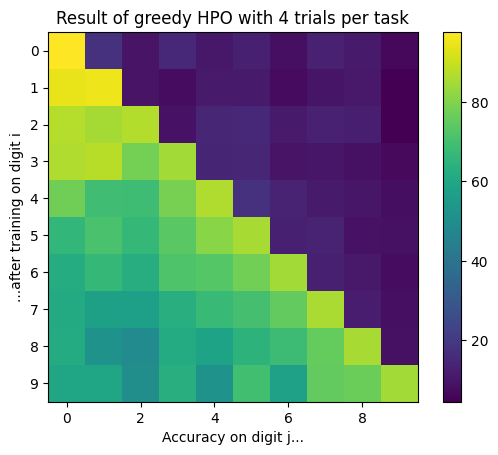

In [23]:
for test_accs_matrix, n_trials in zip(test_accs_matrix_list, n_trials_list) :
    visualize_greedy_HPO_matrix(test_accs_matrix, n_trials, savefig=False)

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [28]:
def visualize_greedy_HPO_curve(test_accs_matrix_list, n_trials_list, savefig=False):
    # Normalize n_trials values for the colormap
    norm = mcolors.LogNorm(vmin=min(n_trials_list), vmax=max(n_trials_list))
    colormap = cm.viridis

    fig, ax = plt.subplots(figsize=(10, 6))
    for test_accs_matrix, n_trials in zip(test_accs_matrix_list, n_trials_list):
        mean_accs = [np.array(test_accs_matrix[i][:i+1]).sum() / (i+1) for i in range(10)]
        color = colormap(norm(n_trials))
        ax.plot(range(10), mean_accs, label=f"{n_trials} trials", color=color)
    
    ax.set_xlabel("Number of classes trained")
    ax.set_ylabel("Average accuracy for classes trained so far")
    ax.set_ylim(0, 100)
    ax.set_title("Result of greedy HPO with various numbers of trials")

    # Create a scalar mappable for the color bar
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Number of Trials')

    ax.legend(loc='lower left')
    
    if savefig:
        plt.savefig(f"results/ICL5_greedy_HPO_curve_LoRA.png")
    
    plt.show()

# Example usage
# visualize_greedy_HPO_curve(test_accs_matrix_list, n_trials_list, savefig=True)


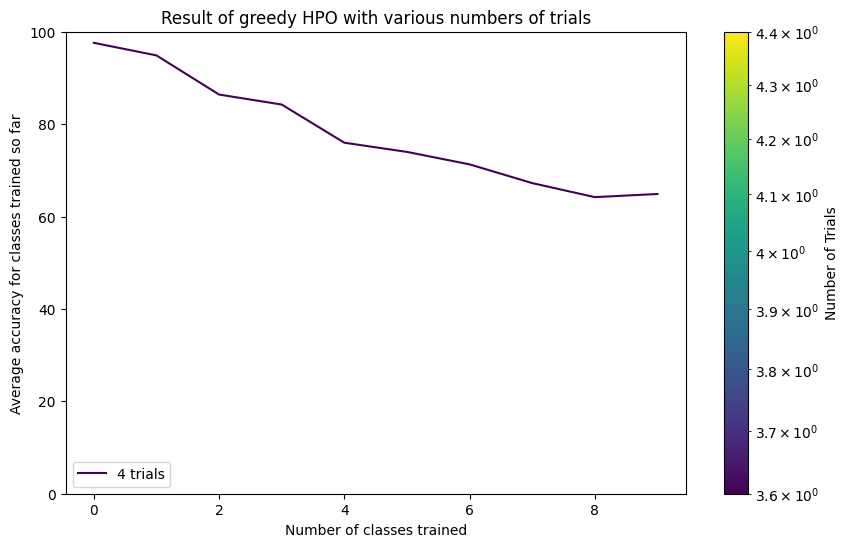

In [29]:
visualize_greedy_HPO_curve(test_accs_matrix_list, n_trials_list, savefig=False)

In [27]:
stop

NameError: name 'stop' is not defined

### Refined greedy HPO

In [ ]:
def call_refined_geedy_HPO(n_trials_task_wise) :
    # Compute scores of the model trained on the first task
    model_path = path + "\\ANN_LoRA\\ICL5_state_dict_digits_0_to_4.pth"

    lora_rank = 16 # The value of this parameters has no influence
    alpha = 1.8 # The value of this parameter has no influence

    lora_ann_model = LoRA_ANN(lora_rank,
                            alpha, 
                            model_path, 
                            num_inputs, 
                            num_hidden, 
                            num_outputs, 
                            batch_size,
                            random_seed).to(device)

    # Test the model trained on digits 0 to 4
    test_accs = np.zeros(10)
    for j in range(5) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
            
    # Initialize variable to store the best HPs and the scores
    best_params = []
    scores = [test_acc]
    test_accs_matrix = [test_accs]
    mean_test_accs_through_past_tasks = [test_acc]

    for i in range(5,10) :
        print(f"Learning Task {i+1}")
        # Perform HPO
        storage = optuna.storages.InMemoryStorage()
        study = optuna.create_study(storage=storage,
                                    study_name="The Search",
                                    sampler=optuna.samplers.TPESampler(seed=random_seed),
                                    direction = "maximize")
        
        params = num_inputs, num_hidden, num_outputs, batch_size
        partial_objective = partial(objective, i, model_path, params, device)
        study.optimize(partial_objective,
                    n_trials=n_trials_task_wise[i-5],
                    timeout=3600)

        # Retrain and save a model with the best params
        best_trial = study.best_trial
        best_params.append(best_trial.params)
        test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
        
        model_path = path + f"ICL5_state_dict_digit_{i}.pth"
        
        # Compute and store scores
        mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
        score = mu - sigma
        
        scores.append(score)
        test_accs_matrix.append(test_accs)
        mean_test_accs_through_past_tasks.append(mu)
    
    return test_accs_matrix

In [ ]:
n_trials_task_wise = [32,32,64,64,128]

In [ ]:
refined_test_accs_matrix = call_refined_geedy_HPO(n_trials_task_wise)

[I 2024-05-28 09:56:31,343] A new study created in memory with name: The Search


Learning Task 6


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]
[I 2024-05-28 09:56:33,541] Trial 0 finished with value: 0.4478114502532753 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4478114502532753.
100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
[I 2024-05-28 09:56:34,491] Trial 1 finished with value: 0.447213595499958 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4478114502532753.
100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
[I 2024-05-28 09:56:35,439] Trial 2 finished with value: 0.4561773478653366 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.4561773478653366.
100%|██████████| 4/4 [00:01<00:00,  2.41it/s]
[I 2024-05-28 09:56:37,630] Trial 3 finished with value: 0.48383932803593416 and parameters: {'lora_rank': 10, 'alp

Learning Task 7


100%|██████████| 4/4 [00:01<00:00,  2.20it/s]
[I 2024-05-28 09:57:23,318] Trial 0 finished with value: 0.43991352341409873 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.43991352341409873.
100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
[I 2024-05-28 09:57:24,389] Trial 1 finished with value: 0.4109005443064499 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.43991352341409873.
100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
[I 2024-05-28 09:57:25,457] Trial 2 finished with value: 0.4293629150430663 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 0 with value: 0.43991352341409873.
100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
[I 2024-05-28 09:57:27,892] Trial 3 finished with value: 0.5474770058755275 and parameters: {'lora_rank': 10, 

Learning Task 8


100%|██████████| 4/4 [00:01<00:00,  2.00it/s]
[I 2024-05-28 09:58:16,867] Trial 0 finished with value: 0.4512160246023868 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.4512160246023868.
100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
[I 2024-05-28 09:58:18,075] Trial 1 finished with value: 0.424311156413519 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.4512160246023868.
100%|██████████| 1/1 [00:00<00:00,  2.03it/s]
[I 2024-05-28 09:58:19,279] Trial 2 finished with value: 0.5032295372488667 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.5032295372488667.
100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
[I 2024-05-28 09:58:21,961] Trial 3 finished with value: 0.7010688081577787 and parameters: {'lora_rank': 10, 'alph

Learning Task 9


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]
[I 2024-05-28 09:59:58,095] Trial 0 finished with value: 0.35665413862206236 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.35665413862206236.
100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
[I 2024-05-28 09:59:59,342] Trial 1 finished with value: 0.35399644036971656 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.35665413862206236.
100%|██████████| 1/1 [00:00<00:00,  2.22it/s]
[I 2024-05-28 10:00:00,586] Trial 2 finished with value: 0.3729021569800334 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.3729021569800334.
100%|██████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-28 10:00:03,200] Trial 3 finished with value: 0.4333146415400987 and parameters: {'lora_rank': 10, 

Learning Task 10


100%|██████████| 4/4 [00:01<00:00,  2.15it/s]
[I 2024-05-28 10:01:49,850] Trial 0 finished with value: 0.37653007734505917 and parameters: {'lora_rank': 29, 'alpha': 1.7678742205327005, 'lr': 0.0005519243111446275, 'num_epochs': 4}. Best is trial 0 with value: 0.37653007734505917.
100%|██████████| 1/1 [00:00<00:00,  2.16it/s]
[I 2024-05-28 10:01:51,196] Trial 1 finished with value: 0.3385367482027919 and parameters: {'lora_rank': 31, 'alpha': 2.2857427546778375, 'lr': 0.0007314714629868308, 'num_epochs': 1}. Best is trial 0 with value: 0.37653007734505917.
100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
[I 2024-05-28 10:01:52,545] Trial 2 finished with value: 0.37771688740136183 and parameters: {'lora_rank': 13, 'alpha': 1.6421037208452025, 'lr': 0.0009323015099616342, 'num_epochs': 1}. Best is trial 2 with value: 0.37771688740136183.
100%|██████████| 4/4 [00:01<00:00,  2.15it/s]
[I 2024-05-28 10:01:55,283] Trial 3 finished with value: 0.45009147291091406 and parameters: {'lora_rank': 10

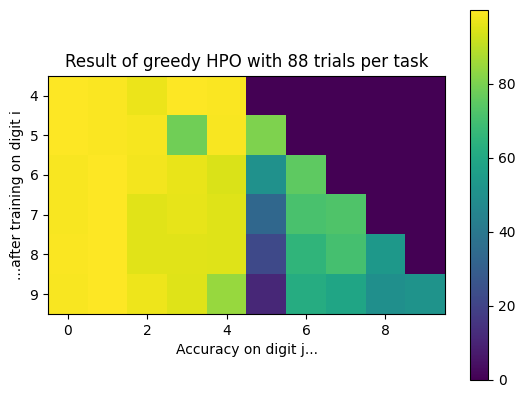

In [ ]:
visualize_greedy_HPO_matrix(refined_test_accs_matrix, 88, savefig=False)

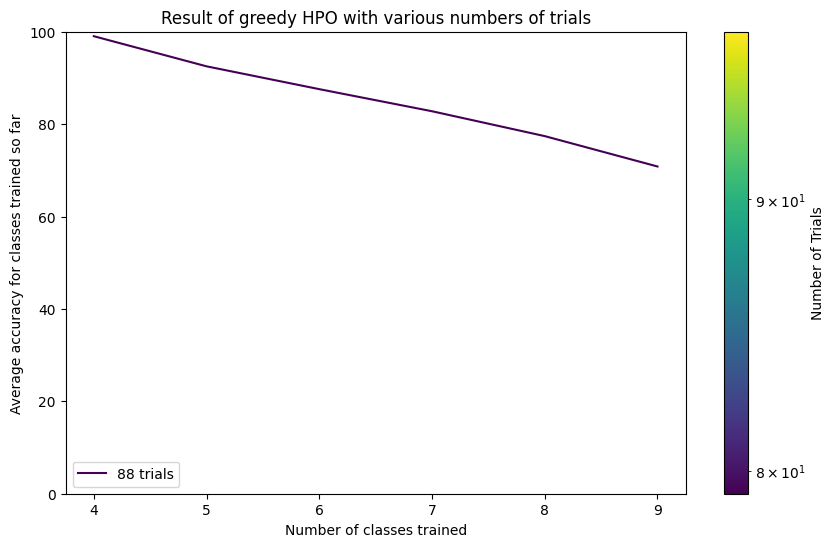

In [ ]:
visualize_greedy_HPO_curve([refined_test_accs_matrix], [88], savefig=False)

## Leaky HPO

In [ ]:
def define_model(model_path, params, lora_rank, alpha) :
    num_inputs, num_hidden, num_outputs, batch_size = params
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size,
                              random_seed)

    return lora_ann_model

def objective(model_path, params, device, trial) :
    # Set HPs
    lr = trial.suggest_float("lr", 1e-4, 3e-4)
    num_epochs = trial.suggest_categorical("num_epochs", [1]) # trial.suggest_int("num_epochs", 1, 4)
    lora_rank = trial.suggest_int("lora_rank", 8, 40)
    alpha = trial.suggest_categorical("alpha", [1.8,1.9,2,2.1])

    l1_sum, l2_sum = 0, 0
    for i in range(5,10) :
        # Define model
        lora_ann_model = define_model(model_path, params, lora_rank, alpha).to(device)
        
        # Train
        batch_size = params[-1]
        
        train_loader = train_loaders_list[i+1]

        train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device, random_seed)

        # Save LoRA weights for future average
        l1_sum += torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
        l2_sum += torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T

        # Save model
        if i < 9 :
            fc1_update = lora_ann_model.model.fc1.weight #+ alpha*torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
            lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
            
            fc2_update = lora_ann_model.model.fc2.weight #+ alpha*torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T
            lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
        else :
            fc1_update = lora_ann_model.model.fc1.weight + alpha*l1_sum/5
            lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
            
            fc2_update = lora_ann_model.model.fc2.weight + alpha*l2_sum/5
            lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
        model_path = path + f"ICL5_state_dict_digit_{i}.pth"
        save(model_path, lora_ann_model.model)

    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    print(test_accs)
    mu = np.mean(test_accs)
    
    return mu

In [ ]:
def call_leaky_HPO(n_trials) :
    # Compute scores of the model trained on the first task
    model_path = path + "\\ANN_LoRA\\ICL5_state_dict_digits_0_to_4.pth"

    lora_rank = 16 # The value of this parameters has no influence
    alpha = 1.8 # The value of this parameter has no influence

    lora_ann_model = LoRA_ANN(lora_rank,
                            alpha, 
                            model_path, 
                            num_inputs, 
                            num_hidden, 
                            num_outputs, 
                            batch_size,
                            random_seed).to(device)

    # Test the model trained on digits 0 to 4
    test_accs = np.zeros(10)
    for j in range(5) :
        test_acc = test(lora_ann_model, test_loaders_list[j+1], batch_size, device)
        test_accs[j] = test_acc
            
    # Initialize variable to store the best HPs and the scores
    test_accs_matrix = [test_accs]

    # Perform HPO
    storage = optuna.storages.InMemoryStorage()
    study = optuna.create_study(storage=storage,
                                study_name="The Search",
                                sampler=optuna.samplers.TPESampler(seed=random_seed),
                                direction = "maximize")
    
    params = num_inputs, num_hidden, num_outputs, batch_size
    partial_objective = partial(objective, model_path, params, device)
    study.optimize(partial_objective,
                   n_trials=n_trials,
                   timeout=3600)
    
    # Return results of best study
    best_trial = study.best_trial
    best_score = best_trial.value
    best_params = best_trial.params

    # Retrain with best parameters
    for i in range(5,10) :
        test_accs = retrain_and_save_with_best_HPs (best_trial, i, model_path)
        model_path = path + f"ICL5_state_dict_digit_{i}.pth"
        test_accs_matrix += [test_accs]
    
    return test_accs_matrix

In [ ]:
test_accs_matrix = call_leaky_HPO(30)

[I 2024-05-28 11:23:52,955] A new study created in memory with name: The Search
100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-28 11:23:56,222] Trial 0 finished with value: 48.19944642857142 and parameters: {'lr': 0.00022951020987060466, 'num_epochs': 1, 'lora_rank': 24, 'alpha': 1.9}. Best is trial 0 with value: 48.19944642857142.


[99.22       97.2675     98.34125    75.89285714 13.84        0.
  0.          0.          0.         97.43285714]


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
[I 2024-05-28 11:23:59,466] Trial 1 finished with value: 50.29060714285715 and parameters: {'lr': 0.00024346767641828014, 'num_epochs': 1, 'lora_rank': 15, 'alpha': 2}. Best is trial 1 with value: 50.29060714285715.


[99.66571429 98.7325     98.145      81.36142857 29.24142857  0.
  0.          0.          0.         95.76      ]


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-28 11:24:02,703] Trial 2 finished with value: 52.587071428571434 and parameters: {'lr': 0.00011798443893679071, 'num_epochs': 1, 'lora_rank': 36, 'alpha': 1.9}. Best is trial 2 with value: 52.587071428571434.


[99.88857143 99.22       98.635      98.10428571 90.62428571  0.
  0.          0.          0.         39.39857143]


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]
[I 2024-05-28 11:24:05,924] Trial 3 finished with value: 52.384392857142856 and parameters: {'lr': 0.0002162891485881896, 'num_epochs': 1, 'lora_rank': 11, 'alpha': 1.8}. Best is trial 2 with value: 52.587071428571434.


[99.88857143 99.3175     98.635      98.10428571 84.37428571  0.
  0.          0.          0.         43.52428571]


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-28 11:24:09,166] Trial 4 finished with value: 52.461571428571425 and parameters: {'lr': 0.00013327911538634009, 'num_epochs': 1, 'lora_rank': 22, 'alpha': 1.9}. Best is trial 2 with value: 52.587071428571434.


[99.88857143 99.22       98.83       98.21571429 87.05428571  0.
  0.          0.          0.         41.40714286]


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
[I 2024-05-28 11:24:12,418] Trial 5 finished with value: 49.90989285714286 and parameters: {'lr': 0.00010643255647485577, 'num_epochs': 1, 'lora_rank': 34, 'alpha': 1.8}. Best is trial 2 with value: 52.587071428571434.


[99.88857143 99.22       98.5375     98.88571429 93.52571429  0.
  0.          0.          0.          9.04142857]


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-28 11:24:15,661] Trial 6 finished with value: 41.34066071428572 and parameters: {'lr': 0.00029572879231709977, 'num_epochs': 1, 'lora_rank': 18, 'alpha': 1.8}. Best is trial 2 with value: 52.587071428571434.


[90.62571429 82.61875    92.285      44.41714286  4.35142857  0.
  0.          0.          0.         99.10857143]


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
[I 2024-05-28 11:24:18,898] Trial 7 finished with value: 28.3805 and parameters: {'lr': 0.00028411059323876927, 'num_epochs': 1, 'lora_rank': 28, 'alpha': 2}. Best is trial 2 with value: 52.587071428571434.


[51.34142857 48.6325     74.9025      8.70571429  0.33428571  0.
  0.          0.          0.         99.88857143]


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
[I 2024-05-28 11:24:22,134] Trial 8 finished with value: 34.59391071428571 and parameters: {'lr': 0.0002636136560104354, 'num_epochs': 1, 'lora_rank': 30, 'alpha': 1.8}. Best is trial 2 with value: 52.587071428571434.


[66.51714286 71.38625    81.25       25.89428571  1.33714286  0.
  0.          0.          0.         99.55428571]


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
[I 2024-05-28 11:24:25,371] Trial 9 finished with value: 52.11389285714286 and parameters: {'lr': 0.0001767414825908611, 'num_epochs': 1, 'lora_rank': 32, 'alpha': 1.9}. Best is trial 2 with value: 52.587071428571434.


[99.88857143 99.1225     99.025      92.18714286 38.39285714  0.
  0.          0.          0.         92.52285714]


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
[I 2024-05-28 11:24:28,625] Trial 10 finished with value: 50.54716071428571 and parameters: {'lr': 0.00016703325921932198, 'num_epochs': 1, 'lora_rank': 40, 'alpha': 2.1}. Best is trial 2 with value: 52.587071428571434.


[99.66571429 98.73125    98.9275     87.16428571 25.55857143  0.
  0.          0.          0.         95.42428571]


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
[I 2024-05-28 11:24:31,866] Trial 11 finished with value: 49.34760714285714 and parameters: {'lr': 0.00010607437543666429, 'num_epochs': 1, 'lora_rank': 21, 'alpha': 1.9}. Best is trial 2 with value: 52.587071428571434.


[99.77714286 99.22       98.0475     99.10857143 97.32285714  0.
  0.          0.          0.          0.        ]


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-28 11:24:35,148] Trial 12 finished with value: 53.87842857142857 and parameters: {'lr': 0.00014410690057454679, 'num_epochs': 1, 'lora_rank': 40, 'alpha': 1.9}. Best is trial 12 with value: 53.87842857142857.


[99.88857143 99.3175     98.7325     97.54428571 68.86142857  0.
  0.          0.          0.         74.44      ]


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-28 11:24:38,414] Trial 13 finished with value: 53.43242857142857 and parameters: {'lr': 0.00014421811091444424, 'num_epochs': 1, 'lora_rank': 39, 'alpha': 1.9}. Best is trial 12 with value: 53.87842857142857.


[99.88857143 99.1225     98.9275     90.40285714 65.17857143  0.
  0.          0.          0.         80.80428571]


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]
[I 2024-05-28 11:24:41,735] Trial 14 finished with value: 52.90632142857144 and parameters: {'lr': 0.0001510231195623101, 'num_epochs': 1, 'lora_rank': 40, 'alpha': 2.1}. Best is trial 12 with value: 53.87842857142857.


[99.77714286 99.22       98.9275     94.08571429 47.76714286  0.
  0.          0.          0.         89.28571429]


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
[I 2024-05-28 11:24:44,987] Trial 15 finished with value: 45.491839285714285 and parameters: {'lr': 0.00019401549383422963, 'num_epochs': 1, 'lora_rank': 36, 'alpha': 1.9}. Best is trial 12 with value: 53.87842857142857.


[98.43714286 90.7225     96.67875    56.02571429 15.06428571  0.
  0.          0.          0.         97.99      ]


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
[I 2024-05-28 11:24:48,222] Trial 16 finished with value: 53.657267857142855 and parameters: {'lr': 0.00014530347441693738, 'num_epochs': 1, 'lora_rank': 27, 'alpha': 1.9}. Best is trial 12 with value: 53.87842857142857.


[99.88857143 99.22       98.73125    97.21       75.67142857  0.
  0.          0.          0.         65.85142857]


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
[I 2024-05-28 11:24:51,501] Trial 17 finished with value: 49.472928571428575 and parameters: {'lr': 0.00018641194098802102, 'num_epochs': 1, 'lora_rank': 27, 'alpha': 1.9}. Best is trial 12 with value: 53.87842857142857.


[99.88857143 98.9275     98.9275     86.38142857 15.51428571  0.
  0.          0.          0.         95.09      ]


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
[I 2024-05-28 11:24:54,756] Trial 18 finished with value: 49.234625 and parameters: {'lr': 0.00016333988869088174, 'num_epochs': 1, 'lora_rank': 10, 'alpha': 2.1}. Best is trial 12 with value: 53.87842857142857.


[99.77714286 99.22       98.14625    99.10857143 95.64857143  0.
  0.          0.          0.          0.44571429]


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-28 11:24:58,010] Trial 19 finished with value: 52.49905357142857 and parameters: {'lr': 0.0001301238269921274, 'num_epochs': 1, 'lora_rank': 27, 'alpha': 2}. Best is trial 12 with value: 53.87842857142857.


[99.88857143 99.22       98.53625    97.88       85.15571429  0.
  0.          0.          0.         44.31      ]


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
[I 2024-05-28 11:25:01,251] Trial 20 finished with value: 53.091857142857144 and parameters: {'lr': 0.00021328616742103133, 'num_epochs': 1, 'lora_rank': 17, 'alpha': 1.9}. Best is trial 12 with value: 53.87842857142857.


[99.88857143 99.3175     99.1225     91.74142857 50.55857143  0.
  0.          0.          0.         90.29      ]


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
[I 2024-05-28 11:25:04,501] Trial 21 finished with value: 53.10871428571429 and parameters: {'lr': 0.0001472375918321498, 'num_epochs': 1, 'lora_rank': 37, 'alpha': 1.9}. Best is trial 12 with value: 53.87842857142857.


[99.88857143 99.22       98.83       91.96285714 51.11857143  0.
  0.          0.          0.         90.06714286]


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-28 11:25:07,744] Trial 22 finished with value: 54.312607142857146 and parameters: {'lr': 0.00014559647066222177, 'num_epochs': 1, 'lora_rank': 32, 'alpha': 1.9}. Best is trial 22 with value: 54.312607142857146.


[99.88857143 99.22       98.9275     97.76857143 82.58857143  0.
  0.          0.          0.         64.73285714]


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-28 11:25:11,006] Trial 23 finished with value: 52.14217857142857 and parameters: {'lr': 0.00012423393770639375, 'num_epochs': 1, 'lora_rank': 31, 'alpha': 1.9}. Best is trial 22 with value: 54.312607142857146.


[99.88857143 99.22       98.5375     98.44       88.84        0.
  0.          0.          0.         36.49571429]


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-28 11:25:14,288] Trial 24 finished with value: 53.39160714285714 and parameters: {'lr': 0.00016055309235965608, 'num_epochs': 1, 'lora_rank': 33, 'alpha': 1.9}. Best is trial 22 with value: 54.312607142857146.


[99.88857143 98.9275     98.83       90.51285714 53.34714286  0.
  0.          0.          0.         92.41      ]


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]
[I 2024-05-28 11:25:17,539] Trial 25 finished with value: 53.54414285714286 and parameters: {'lr': 0.00013786567573532353, 'num_epochs': 1, 'lora_rank': 29, 'alpha': 1.9}. Best is trial 22 with value: 54.312607142857146.


[99.88857143 99.3175     98.7325     97.88142857 89.28571429  0.
  0.          0.          0.         50.33571429]


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
[I 2024-05-28 11:25:20,793] Trial 26 finished with value: 53.561821428571434 and parameters: {'lr': 0.00017833811012067674, 'num_epochs': 1, 'lora_rank': 25, 'alpha': 1.9}. Best is trial 22 with value: 54.312607142857146.


[99.88857143 99.22       99.1225     86.94142857 66.40571429  0.
  0.          0.          0.         84.04      ]


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
[I 2024-05-28 11:25:24,052] Trial 27 finished with value: 45.734267857142854 and parameters: {'lr': 0.00020005283122564077, 'num_epochs': 1, 'lora_rank': 34, 'alpha': 2}. Best is trial 22 with value: 54.312607142857146.


[98.99714286 87.10875    97.4625     71.09571429  4.35142857  0.
  0.          0.          0.         98.32714286]


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
[I 2024-05-28 11:25:27,401] Trial 28 finished with value: 54.40467857142856 and parameters: {'lr': 0.00011628036509794045, 'num_epochs': 1, 'lora_rank': 37, 'alpha': 2.1}. Best is trial 28 with value: 54.40467857142856.


[99.88857143 99.22       98.7325     96.31714286 79.8         0.
  0.          0.          0.         70.08857143]


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
[I 2024-05-28 11:25:30,702] Trial 29 finished with value: 52.373678571428584 and parameters: {'lr': 0.00010232248172513839, 'num_epochs': 1, 'lora_rank': 38, 'alpha': 2.1}. Best is trial 28 with value: 54.40467857142856.


[99.88857143 99.22       98.7325     97.65571429 88.17142857  0.
  0.          0.          0.         40.06857143]


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


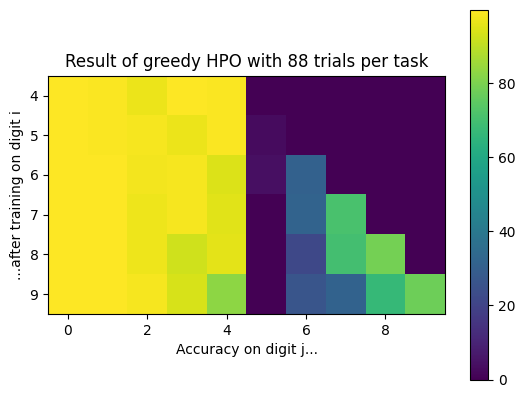

In [ ]:
visualize_greedy_HPO_matrix(test_accs_matrix, 88, savefig=False)

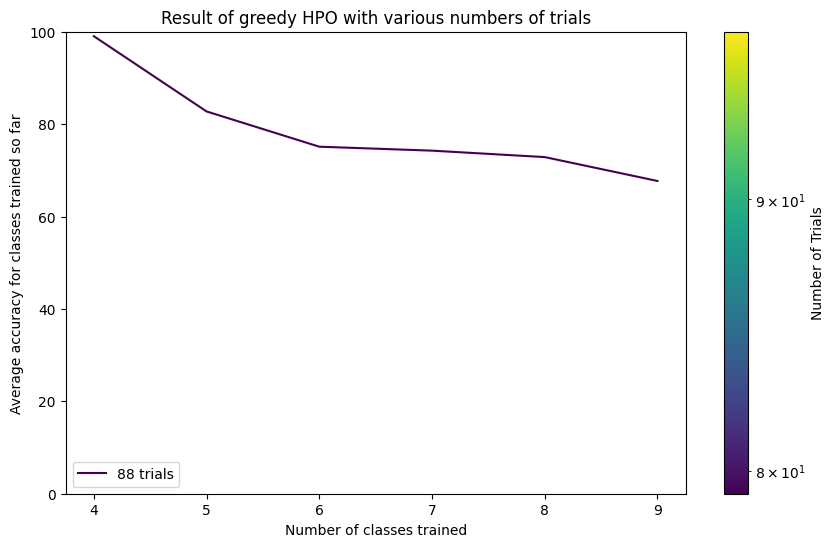

In [ ]:
visualize_greedy_HPO_curve([test_accs_matrix], [88], savefig=False)